In [1]:
pip install --upgrade torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


In [5]:
set_seed(42)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()
        self.transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor(),
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        for i, monet in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = monet
        for i, photo in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = photo
            
    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))
    
    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        return photo_img, monet_img

In [7]:
img_ds = ImageDataset('../input/gan-getting-started/monet_jpg/', '../input/gan-getting-started/photo_jpg/')

img_dl = DataLoader(img_ds, batch_size=4, pin_memory=True) # pin_memory enables fast data transfer to CUDA-enabled GPUs

In [8]:
photo_img, monet_img = next(iter(img_dl))

trans = transforms.Compose([transforms.Normalize(mean=[-1], std=[2])])

photo_img = trans(photo_img)
monet_img = trans(monet_img)

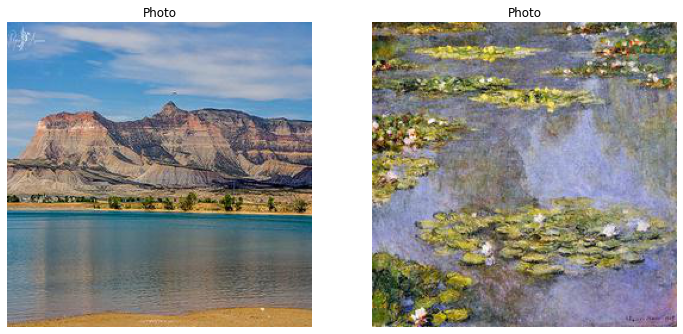

In [9]:
fig, axes = plt.subplots(1, 2)

axes[0].axis('off')
axes[0].imshow(photo_img[0].numpy().transpose(1, 2, 0))
axes[0].set_title("Photo")

axes[1].axis('off')
axes[1].imshow(monet_img[0].numpy().transpose(1, 2, 0))
axes[1].set_title("Photo")

fig.set_figwidth(12)   
fig.set_figheight(6) 
plt.show()

In [10]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

In [11]:
def Upsample(in_ch, out_ch, dropout_ratio=0.5):
    return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.SiLU()
        )


In [12]:
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)


    norm = nn.InstanceNorm2d(out_ch) #

    return nn.Sequential(conv, norm, actv)

In [13]:
class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))    # making 1-layer padding near input tensor
        layers.append(Convlayer(in_features, in_features, 3, 1, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        layers.append(nn.SiLU())
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)


In [14]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))    # making 3-layer padding near input tensor
        model.append(Convlayer(in_ch, 64, 7, 1, use_pad=False))
        model.append(Convlayer(64, 128, 3, 2))
        model.append(Convlayer(128, 256, 3, 2))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0)) # taking away old padding
        model.append(nn.Tanh()) # activation function

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x) # returning our ready generator model

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers-1:
                model.append(Convlayer(in_chs, out_chs, 4, 1)) # for the penultimate case stride will be 1
            else:
                model.append(Convlayer(in_chs, out_chs, 4, 2)) # stride 2
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)) # and the same situation for the last case
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x) # returning our ready dicriminator model


In [16]:
def init_weights(net, gain=0.02):
    def init_func(m):
        """
        Checking if our classes Generator and Discriminatore have methods weight or bias, in this case we fill
        the input weight tensor from weight.data or bias.data with values drawn from the normal distribution 
        N(mean, std**2) and the input bias tensor we fill with 0
        """
        classname = m.__class__.__name__ # here we're getting our class name (Generator or Discriminator)
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1): 
            init.normal_(m.weight.data, 0.0, gain) # initalizing weight tensor
            if hasattr(m, 'bias') and m.bias is not None:
                init.zeros_(m.bias.data) # filling bias tensor with zeroes
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.zeros_(m.bias.data)
    net.apply(init_func) # applying function to every submodule of our hand-made net

In [17]:
def update_req_grad(models, requires_grad=True):
    """
    We need gradients to be computed for Discriminator and not to be computed for Generator
    """
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [18]:
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs): # useful method which helps us not to write the name of method just exmp(args)
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [19]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

In [20]:
import gc

class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        
        self.sgd_gen = torch.optim.SGD(
            itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
            lr=start_lr,
            momentum = 0.9
        )
        self.sgd_desc = torch.optim.SGD(
            itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()), 
            lr = start_lr, 
            momentum = 0.9
        )
        
        self.adam_gen = torch.optim.RAdam(
            itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()), 
            lr = start_lr, 
            betas=(0.5, 0.999)
        )
        self.adam_desc = torch.optim.RAdam(
            itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()), 
            lr = start_lr, 
            betas=(0.5, 0.999)
        )
        
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        
        self.gen_sgd_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.sgd_gen, 
                                                              lr_lambda=lambda epoch: 1 - max(0, epoch-decay_epoch) / (epochs-decay_epoch))
        self.desc_sgd_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.sgd_desc, 
                                                               lr_lambda=lambda epoch: 1 - max(0, epoch-decay_epoch) / (epochs-decay_epoch))
        
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, 
                                                              lr_lambda=lambda epoch: 1 - max(0, epoch-decay_epoch) / (epochs-decay_epoch))
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, 
                                                               lr_lambda=lambda epoch: 1 - max(0, epoch-decay_epoch) / (epochs-decay_epoch))
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl, flag=True):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                
                if flag:
                    self.adam_gen.zero_grad()
                else:
                    self.sgd_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                if flag:
                    self.adam_gen.step()
                else:
                    self.sgd_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                if flag:
                    self.adam_desc.zero_grad()
                else:
                    self.sgd_desc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                if flag:
                    self.adam_desc.step()
                else:
                    self.sgd_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_mtp': gan.gen_mtp.state_dict(),
                'gen_ptm': gan.gen_ptm.state_dict(),
                'desc_m': gan.desc_m.state_dict(),
                'desc_p': gan.desc_p.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_desc': gan.adam_desc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
            if flag:
                self.gen_lr_sched.step()
                self.desc_lr_sched.step()
            else:
                self.gen_sgd_lr_sched.step()
                self.desc_sgd_lr_sched.step()
            
            gc.collect()
            torch.cuda.empty_cache()

In [21]:
torch.cuda.empty_cache()

In [22]:
gan = CycleGAN(3, 3, 200, device)

In [23]:
# Save before train
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'desc_m': gan.desc_m.state_dict(),
    'desc_p': gan.desc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_desc': gan.adam_desc.state_dict()
}

In [24]:
save_checkpoint(save_dict, 'init.ckpt')

In [25]:
gan.train(img_dl)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:17.180293 | Discriminator Loss:1.953130


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:11.252014 | Discriminator Loss:0.862061


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:9.966776 | Discriminator Loss:0.558024


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:9.394130 | Discriminator Loss:0.464019


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:9.342610 | Discriminator Loss:0.435302


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:8.945198 | Discriminator Loss:0.443957


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:8.789654 | Discriminator Loss:0.401283


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:8.347655 | Discriminator Loss:0.378345


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:8.224803 | Discriminator Loss:0.392749


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:8.034217 | Discriminator Loss:0.438727


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:7.826128 | Discriminator Loss:0.398964


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:8.054465 | Discriminator Loss:0.365950


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:7.936228 | Discriminator Loss:0.365630


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:7.641635 | Discriminator Loss:0.362189


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:7.655735 | Discriminator Loss:0.351308


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:7.596101 | Discriminator Loss:0.361621


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:7.598573 | Discriminator Loss:0.377057


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:7.563425 | Discriminator Loss:0.330671


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:7.513867 | Discriminator Loss:0.313775


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:7.545636 | Discriminator Loss:0.350419


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:7.377391 | Discriminator Loss:0.322715


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:7.414429 | Discriminator Loss:0.310232


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:7.280556 | Discriminator Loss:0.334401


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:7.173432 | Discriminator Loss:0.328732


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:7.279006 | Discriminator Loss:0.317365


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:7.249392 | Discriminator Loss:0.342891


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:7.251764 | Discriminator Loss:0.311558


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:7.382206 | Discriminator Loss:0.311080


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:6.948474 | Discriminator Loss:0.300157


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:6.923316 | Discriminator Loss:0.336410


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (31) | Generator Loss:6.976601 | Discriminator Loss:0.340792


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (32) | Generator Loss:6.987258 | Discriminator Loss:0.349942


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (33) | Generator Loss:6.866474 | Discriminator Loss:0.324794


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (34) | Generator Loss:6.774287 | Discriminator Loss:0.349732


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (35) | Generator Loss:6.782429 | Discriminator Loss:0.332944


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (36) | Generator Loss:6.775975 | Discriminator Loss:0.373955


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (37) | Generator Loss:6.718496 | Discriminator Loss:0.325631


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (38) | Generator Loss:6.528677 | Discriminator Loss:0.344141


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (39) | Generator Loss:6.768572 | Discriminator Loss:0.315312


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (40) | Generator Loss:6.776800 | Discriminator Loss:0.345216


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (41) | Generator Loss:6.519114 | Discriminator Loss:0.326617


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (42) | Generator Loss:6.402804 | Discriminator Loss:0.346600


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (43) | Generator Loss:6.541642 | Discriminator Loss:0.322451


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (44) | Generator Loss:6.509619 | Discriminator Loss:0.339162


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (45) | Generator Loss:6.491672 | Discriminator Loss:0.327844


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (46) | Generator Loss:6.348734 | Discriminator Loss:0.319304


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (47) | Generator Loss:6.918638 | Discriminator Loss:0.315614


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (48) | Generator Loss:6.457724 | Discriminator Loss:0.319317


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (49) | Generator Loss:6.536935 | Discriminator Loss:0.334161


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (50) | Generator Loss:6.439327 | Discriminator Loss:0.315448


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (51) | Generator Loss:6.260264 | Discriminator Loss:0.328468


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (52) | Generator Loss:6.335686 | Discriminator Loss:0.319101


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (53) | Generator Loss:6.294933 | Discriminator Loss:0.306000


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (54) | Generator Loss:6.300757 | Discriminator Loss:0.314574


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (55) | Generator Loss:6.176311 | Discriminator Loss:0.311878


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (56) | Generator Loss:6.399657 | Discriminator Loss:0.313137


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (57) | Generator Loss:6.212440 | Discriminator Loss:0.331798


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (58) | Generator Loss:6.030523 | Discriminator Loss:0.325310


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (59) | Generator Loss:6.194372 | Discriminator Loss:0.317736


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (60) | Generator Loss:6.072060 | Discriminator Loss:0.317516


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (61) | Generator Loss:6.072160 | Discriminator Loss:0.308745


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (62) | Generator Loss:6.159471 | Discriminator Loss:0.310337


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (63) | Generator Loss:6.083579 | Discriminator Loss:0.302017


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (64) | Generator Loss:6.102974 | Discriminator Loss:0.300943


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (65) | Generator Loss:5.973036 | Discriminator Loss:0.305516


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (66) | Generator Loss:6.047781 | Discriminator Loss:0.299223


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (67) | Generator Loss:6.033696 | Discriminator Loss:0.296439


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (68) | Generator Loss:6.168926 | Discriminator Loss:0.277425


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (69) | Generator Loss:6.044631 | Discriminator Loss:0.288556


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (70) | Generator Loss:5.852240 | Discriminator Loss:0.287189


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (71) | Generator Loss:5.962050 | Discriminator Loss:0.296711


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (72) | Generator Loss:6.012824 | Discriminator Loss:0.278572


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (73) | Generator Loss:5.902070 | Discriminator Loss:0.292344


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (74) | Generator Loss:5.880609 | Discriminator Loss:0.299037


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (75) | Generator Loss:5.704024 | Discriminator Loss:0.284390


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (76) | Generator Loss:5.839605 | Discriminator Loss:0.273042


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (77) | Generator Loss:5.886060 | Discriminator Loss:0.287882


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (78) | Generator Loss:5.834429 | Discriminator Loss:0.280429


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (79) | Generator Loss:5.743280 | Discriminator Loss:0.282212


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (80) | Generator Loss:5.721419 | Discriminator Loss:0.266901


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (81) | Generator Loss:5.810985 | Discriminator Loss:0.278996


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (82) | Generator Loss:5.913347 | Discriminator Loss:0.259477


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (83) | Generator Loss:6.005107 | Discriminator Loss:0.256115


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (84) | Generator Loss:5.743352 | Discriminator Loss:0.249363


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (85) | Generator Loss:5.625481 | Discriminator Loss:0.251257


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (86) | Generator Loss:5.603761 | Discriminator Loss:0.254979


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (87) | Generator Loss:5.678612 | Discriminator Loss:0.239228


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (88) | Generator Loss:5.688755 | Discriminator Loss:0.226022


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (89) | Generator Loss:5.632651 | Discriminator Loss:0.241192


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (90) | Generator Loss:5.788212 | Discriminator Loss:0.228053


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (91) | Generator Loss:5.624889 | Discriminator Loss:0.227085


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (92) | Generator Loss:5.829737 | Discriminator Loss:0.208193


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (93) | Generator Loss:5.694956 | Discriminator Loss:0.192337


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (94) | Generator Loss:5.771373 | Discriminator Loss:0.187440


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (95) | Generator Loss:5.677117 | Discriminator Loss:0.202158


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (96) | Generator Loss:5.724934 | Discriminator Loss:0.180991


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (97) | Generator Loss:5.695086 | Discriminator Loss:0.175644


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (98) | Generator Loss:5.708266 | Discriminator Loss:0.165706


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (99) | Generator Loss:5.777764 | Discriminator Loss:0.153204


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (100) | Generator Loss:5.631807 | Discriminator Loss:0.167793


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (101) | Generator Loss:5.689070 | Discriminator Loss:0.154334


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (102) | Generator Loss:5.684182 | Discriminator Loss:0.156903


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (103) | Generator Loss:5.676156 | Discriminator Loss:0.135782


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (104) | Generator Loss:5.629474 | Discriminator Loss:0.148293


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (105) | Generator Loss:5.635787 | Discriminator Loss:0.153979


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (106) | Generator Loss:5.591919 | Discriminator Loss:0.164426


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (107) | Generator Loss:5.742263 | Discriminator Loss:0.134756


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (108) | Generator Loss:6.385311 | Discriminator Loss:0.129863


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (109) | Generator Loss:5.890924 | Discriminator Loss:0.125874


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (110) | Generator Loss:5.853205 | Discriminator Loss:0.126755


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (111) | Generator Loss:5.803051 | Discriminator Loss:0.116155


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (112) | Generator Loss:5.842813 | Discriminator Loss:0.111799


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (113) | Generator Loss:5.680106 | Discriminator Loss:0.126532


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (114) | Generator Loss:5.532075 | Discriminator Loss:0.124329


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (115) | Generator Loss:5.458822 | Discriminator Loss:0.136299


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (116) | Generator Loss:5.527330 | Discriminator Loss:0.167231


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (117) | Generator Loss:5.362760 | Discriminator Loss:0.145915


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (118) | Generator Loss:5.446270 | Discriminator Loss:0.134035


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (119) | Generator Loss:5.601072 | Discriminator Loss:0.130274


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (120) | Generator Loss:5.490083 | Discriminator Loss:0.127547


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (121) | Generator Loss:5.480426 | Discriminator Loss:0.158284


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (122) | Generator Loss:5.424003 | Discriminator Loss:0.147794


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (123) | Generator Loss:5.563512 | Discriminator Loss:0.163225


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (124) | Generator Loss:5.338372 | Discriminator Loss:0.158889


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (125) | Generator Loss:5.390517 | Discriminator Loss:0.141924


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (126) | Generator Loss:5.331770 | Discriminator Loss:0.150958


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (127) | Generator Loss:5.331823 | Discriminator Loss:0.148503


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (128) | Generator Loss:5.382001 | Discriminator Loss:0.132213


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (129) | Generator Loss:5.909748 | Discriminator Loss:0.129227


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (130) | Generator Loss:5.665126 | Discriminator Loss:0.144072


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (131) | Generator Loss:5.451610 | Discriminator Loss:0.116874


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (132) | Generator Loss:5.441700 | Discriminator Loss:0.119131


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (133) | Generator Loss:5.561145 | Discriminator Loss:0.133508


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (134) | Generator Loss:5.386777 | Discriminator Loss:0.114372


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (135) | Generator Loss:5.377674 | Discriminator Loss:0.115441


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (136) | Generator Loss:5.433032 | Discriminator Loss:0.114801


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (137) | Generator Loss:5.453574 | Discriminator Loss:0.120506


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (138) | Generator Loss:5.388058 | Discriminator Loss:0.120956


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (139) | Generator Loss:5.336171 | Discriminator Loss:0.114559


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (140) | Generator Loss:5.228513 | Discriminator Loss:0.126286


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (141) | Generator Loss:5.285846 | Discriminator Loss:0.140074


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (142) | Generator Loss:5.293922 | Discriminator Loss:0.144181


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (143) | Generator Loss:5.375457 | Discriminator Loss:0.158921


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (144) | Generator Loss:5.257731 | Discriminator Loss:0.147326


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (145) | Generator Loss:5.294245 | Discriminator Loss:0.138313


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (146) | Generator Loss:5.271031 | Discriminator Loss:0.122103


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (147) | Generator Loss:5.200816 | Discriminator Loss:0.126414


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (148) | Generator Loss:5.272724 | Discriminator Loss:0.123771


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (149) | Generator Loss:5.366330 | Discriminator Loss:0.119261


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (150) | Generator Loss:5.350619 | Discriminator Loss:0.107102


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (151) | Generator Loss:5.300448 | Discriminator Loss:0.105107


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (152) | Generator Loss:5.288677 | Discriminator Loss:0.107800


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (153) | Generator Loss:5.260135 | Discriminator Loss:0.105041


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (154) | Generator Loss:5.354121 | Discriminator Loss:0.102125


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (155) | Generator Loss:5.367627 | Discriminator Loss:0.104024


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (156) | Generator Loss:5.358900 | Discriminator Loss:0.109171


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (157) | Generator Loss:5.260754 | Discriminator Loss:0.108140


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (158) | Generator Loss:5.272283 | Discriminator Loss:0.099547


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (159) | Generator Loss:5.357653 | Discriminator Loss:0.101884


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (160) | Generator Loss:5.332471 | Discriminator Loss:0.090155


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (161) | Generator Loss:5.330609 | Discriminator Loss:0.092698


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (162) | Generator Loss:5.322067 | Discriminator Loss:0.090508


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (163) | Generator Loss:5.238702 | Discriminator Loss:0.129666


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (164) | Generator Loss:5.197767 | Discriminator Loss:0.103384


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (165) | Generator Loss:5.379572 | Discriminator Loss:0.102979


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (166) | Generator Loss:5.424374 | Discriminator Loss:0.097027


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (167) | Generator Loss:5.245341 | Discriminator Loss:0.091966


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (168) | Generator Loss:5.340455 | Discriminator Loss:0.095760


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (169) | Generator Loss:5.304121 | Discriminator Loss:0.099586


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (170) | Generator Loss:5.342144 | Discriminator Loss:0.087877


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (171) | Generator Loss:5.345488 | Discriminator Loss:0.078820


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (172) | Generator Loss:5.335407 | Discriminator Loss:0.080858


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (173) | Generator Loss:5.349606 | Discriminator Loss:0.077390


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (174) | Generator Loss:5.284390 | Discriminator Loss:0.078836


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (175) | Generator Loss:5.309581 | Discriminator Loss:0.079754


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (176) | Generator Loss:5.309607 | Discriminator Loss:0.078618


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (177) | Generator Loss:5.332769 | Discriminator Loss:0.075652


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (178) | Generator Loss:5.376294 | Discriminator Loss:0.070488


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (179) | Generator Loss:5.389724 | Discriminator Loss:0.076333


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (180) | Generator Loss:5.367044 | Discriminator Loss:0.070705


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (181) | Generator Loss:5.320843 | Discriminator Loss:0.072558


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (182) | Generator Loss:5.356139 | Discriminator Loss:0.073177


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (183) | Generator Loss:5.355307 | Discriminator Loss:0.073411


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (184) | Generator Loss:5.479256 | Discriminator Loss:0.075118


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (185) | Generator Loss:5.432305 | Discriminator Loss:0.070646


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (186) | Generator Loss:5.449750 | Discriminator Loss:0.072869


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (187) | Generator Loss:5.399199 | Discriminator Loss:0.069635


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (188) | Generator Loss:5.266274 | Discriminator Loss:0.067320


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (189) | Generator Loss:5.237375 | Discriminator Loss:0.064932


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (190) | Generator Loss:5.563754 | Discriminator Loss:0.062789


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (191) | Generator Loss:5.493972 | Discriminator Loss:0.063940


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (192) | Generator Loss:5.318845 | Discriminator Loss:0.064789


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (193) | Generator Loss:5.408239 | Discriminator Loss:0.062538


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (194) | Generator Loss:5.354375 | Discriminator Loss:0.060977


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (195) | Generator Loss:5.447628 | Discriminator Loss:0.059186


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (196) | Generator Loss:5.361043 | Discriminator Loss:0.059483


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (197) | Generator Loss:5.438698 | Discriminator Loss:0.060412


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (198) | Generator Loss:5.315048 | Discriminator Loss:0.058335


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (199) | Generator Loss:5.415498 | Discriminator Loss:0.057693


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (200) | Generator Loss:5.386742 | Discriminator Loss:0.057359


In [26]:
gan.epochs = 100

In [27]:
gan.train(img_dl, False)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:5.410110 | Discriminator Loss:0.471694


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:4.807067 | Discriminator Loss:0.486902


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:4.789992 | Discriminator Loss:0.370787


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:4.631865 | Discriminator Loss:0.400701


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:4.732496 | Discriminator Loss:0.331189


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:4.771652 | Discriminator Loss:0.289156


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:4.850007 | Discriminator Loss:0.260818


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:4.973043 | Discriminator Loss:0.206047


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:4.952945 | Discriminator Loss:0.205508


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:4.999978 | Discriminator Loss:0.197753


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:4.950549 | Discriminator Loss:0.192378


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:4.914297 | Discriminator Loss:0.197291


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:4.954550 | Discriminator Loss:0.286423


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:4.926712 | Discriminator Loss:0.184934


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:5.097995 | Discriminator Loss:0.161117


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:5.125936 | Discriminator Loss:0.130375


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:5.071786 | Discriminator Loss:0.157114


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:5.216826 | Discriminator Loss:0.150879


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:5.136679 | Discriminator Loss:0.121390


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:5.117248 | Discriminator Loss:0.119325


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:5.313146 | Discriminator Loss:0.123326


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:5.246870 | Discriminator Loss:0.122680


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:5.310583 | Discriminator Loss:0.108851


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:5.205133 | Discriminator Loss:0.125952


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:5.179904 | Discriminator Loss:0.107161


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:5.154913 | Discriminator Loss:0.097456


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:5.286545 | Discriminator Loss:0.103227


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:5.141139 | Discriminator Loss:0.097535


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:5.266067 | Discriminator Loss:0.097649


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:5.365334 | Discriminator Loss:0.083718


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (31) | Generator Loss:5.276910 | Discriminator Loss:0.090722


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (32) | Generator Loss:5.334448 | Discriminator Loss:0.083559


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (33) | Generator Loss:5.328190 | Discriminator Loss:0.097578


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (34) | Generator Loss:5.208441 | Discriminator Loss:0.107966


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (35) | Generator Loss:5.337972 | Discriminator Loss:0.104266


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (36) | Generator Loss:5.283008 | Discriminator Loss:0.092467


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (37) | Generator Loss:5.394230 | Discriminator Loss:0.108546


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (38) | Generator Loss:5.282124 | Discriminator Loss:0.111478


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (39) | Generator Loss:5.249619 | Discriminator Loss:0.100148


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (40) | Generator Loss:5.286168 | Discriminator Loss:0.090708


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (41) | Generator Loss:5.267212 | Discriminator Loss:0.075399


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (42) | Generator Loss:5.343065 | Discriminator Loss:0.091699


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (43) | Generator Loss:5.362798 | Discriminator Loss:0.077300


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (44) | Generator Loss:5.302868 | Discriminator Loss:0.089309


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (45) | Generator Loss:5.273662 | Discriminator Loss:0.079734


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (46) | Generator Loss:5.295282 | Discriminator Loss:0.084672


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (47) | Generator Loss:5.332090 | Discriminator Loss:0.074374


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (48) | Generator Loss:5.418743 | Discriminator Loss:0.072952


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (49) | Generator Loss:5.307363 | Discriminator Loss:0.076487


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (50) | Generator Loss:5.352983 | Discriminator Loss:0.066588


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (51) | Generator Loss:5.367734 | Discriminator Loss:0.070086


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (52) | Generator Loss:5.397392 | Discriminator Loss:0.075836


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (53) | Generator Loss:5.329592 | Discriminator Loss:0.068952


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (54) | Generator Loss:5.455778 | Discriminator Loss:0.069536


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (55) | Generator Loss:5.375775 | Discriminator Loss:0.065233


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (56) | Generator Loss:5.429324 | Discriminator Loss:0.064851


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (57) | Generator Loss:5.407555 | Discriminator Loss:0.069971


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (58) | Generator Loss:5.460181 | Discriminator Loss:0.066949


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (59) | Generator Loss:5.379778 | Discriminator Loss:0.064111


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (60) | Generator Loss:5.446061 | Discriminator Loss:0.069522


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (61) | Generator Loss:5.520038 | Discriminator Loss:0.078490


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (62) | Generator Loss:5.618778 | Discriminator Loss:0.075600


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (63) | Generator Loss:5.513202 | Discriminator Loss:0.080440


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (64) | Generator Loss:5.567086 | Discriminator Loss:0.078920


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (65) | Generator Loss:5.534641 | Discriminator Loss:0.076160


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (66) | Generator Loss:5.492901 | Discriminator Loss:0.072077


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (67) | Generator Loss:5.361775 | Discriminator Loss:0.092634


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (68) | Generator Loss:5.378064 | Discriminator Loss:0.091026


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (69) | Generator Loss:5.429497 | Discriminator Loss:0.093743


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (70) | Generator Loss:5.306300 | Discriminator Loss:0.088329


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (71) | Generator Loss:5.377225 | Discriminator Loss:0.082804


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (72) | Generator Loss:5.354771 | Discriminator Loss:0.071717


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (73) | Generator Loss:5.395875 | Discriminator Loss:0.076825


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (74) | Generator Loss:5.389766 | Discriminator Loss:0.067765


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (75) | Generator Loss:5.412817 | Discriminator Loss:0.063893


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (76) | Generator Loss:5.434422 | Discriminator Loss:0.072431


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (77) | Generator Loss:5.429464 | Discriminator Loss:0.083415


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (78) | Generator Loss:5.304931 | Discriminator Loss:0.075704


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (79) | Generator Loss:5.275219 | Discriminator Loss:0.075622


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (80) | Generator Loss:5.326527 | Discriminator Loss:0.074157


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (81) | Generator Loss:5.351329 | Discriminator Loss:0.079296


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (82) | Generator Loss:5.314520 | Discriminator Loss:0.092151


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (83) | Generator Loss:5.374871 | Discriminator Loss:0.076286


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (84) | Generator Loss:5.305330 | Discriminator Loss:0.107952


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (85) | Generator Loss:5.418150 | Discriminator Loss:0.092862


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (86) | Generator Loss:5.308011 | Discriminator Loss:0.086997


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (87) | Generator Loss:5.279989 | Discriminator Loss:0.088272


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (88) | Generator Loss:5.351705 | Discriminator Loss:0.085765


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (89) | Generator Loss:5.380733 | Discriminator Loss:0.080358


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (90) | Generator Loss:5.315584 | Discriminator Loss:0.086049


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (91) | Generator Loss:5.330900 | Discriminator Loss:0.074219


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (92) | Generator Loss:5.404612 | Discriminator Loss:0.074381


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (93) | Generator Loss:5.423359 | Discriminator Loss:0.076425


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (94) | Generator Loss:5.388180 | Discriminator Loss:0.084362


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (95) | Generator Loss:5.508775 | Discriminator Loss:0.080700


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (96) | Generator Loss:5.400061 | Discriminator Loss:0.079938


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (97) | Generator Loss:5.337762 | Discriminator Loss:0.070688


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (98) | Generator Loss:5.347920 | Discriminator Loss:0.070978


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (99) | Generator Loss:5.356689 | Discriminator Loss:0.074557


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: (100) | Generator Loss:5.277938 | Discriminator Loss:0.078461


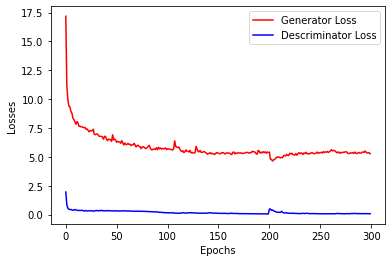

In [28]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

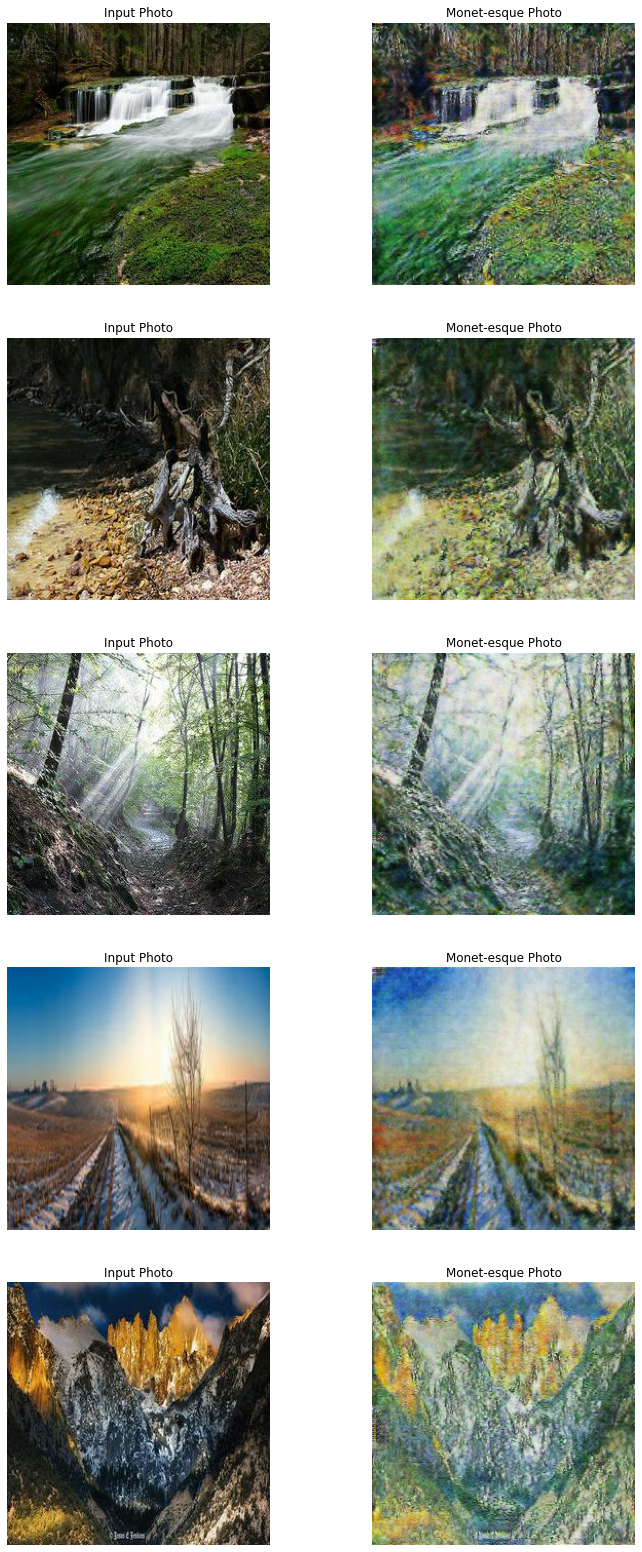

In [29]:
fig, axes = plt.subplots(5, 2)

for i in range(5):
    photo_img, _ = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = trans(photo_img)
    pred_monet = trans(pred_monet)
    
    axes[i, 0].axis('off')
    axes[i, 0].imshow(photo_img[0].numpy().transpose(1, 2, 0))
    axes[i, 0].set_title("Input Photo")

    axes[i, 1].axis('off')
    axes[i, 1].imshow(pred_monet[0].numpy().transpose(1, 2, 0))
    axes[i, 1].set_title("Monet-esque Photo")

fig.set_figwidth(12)   
fig.set_figheight(28) 
plt.show()

In [30]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img
    
    def __len__(self):
        return len(self.photo_idx.keys())

In [31]:
ph_ds = PhotoDataset('../input/gan-getting-started/photo_jpg/')

In [32]:
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)

In [33]:
!mkdir ../images

In [34]:
pil_trans = transforms.ToPILImage()

In [35]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

In [36]:
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    pred_monet = unnorm(pred_monet)
    img = pil_trans(pred_monet[0]).convert("RGB")
    img.save("../images/" + str(i+1) + ".jpg")

  0%|          | 0/7038 [00:00<?, ?it/s]

In [37]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'